In [1]:
# activate conda environment
# conda activate cellpose
# the version is 3.8.12

In [2]:
import os
import subprocess
from cellpose import models, io
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

In [3]:
def crop_roi(path_img, path_mask, path_outdir, size=100, sum=False):
    #画像の読み込み
    cv2_img = cv2.imread(path_img)
    cv2_mask = path_mask
    lower_limit = 1
    upper_limit = int(np.max(cv2_mask) + 1)
    
    path_outdir_bitwise = os.path.join(path_outdir, "bitwise_image")
    os.makedirs(path_outdir_bitwise, exist_ok=True)
    
    path_outdir_gray = os.path.join(path_outdir, "gray_image")
    os.makedirs(path_outdir_gray, exist_ok=True)
    
    path_outdir_crop = os.path.join(path_outdir, "crop_image")
    os.makedirs(path_outdir_crop, exist_ok=True)
    
    print("===", path_img, "===")
    
    for threshold in tqdm(range(lower_limit, upper_limit)):
        mask = cv2.inRange(cv2_mask, threshold, threshold)
        if mask.sum() == 0:
            continue
        else:
            binary_image = mask.astype(np.uint8)
            
            # マスク画像の輪郭を修正
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
            dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
            closed_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel)
            
            cv2_img_bitwise = cv2.bitwise_and(cv2_img, cv2_img, mask=closed_image)         
            
            contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for index, contour in enumerate(contours):
                # # ROIを作成
                # x, y, w, h = cv2.boundingRect(contour)
                # roi = cv2_img[y:y+h, x:x+w]

                # ROIの重心を計算
                # 輪郭が存在するか確認
                M = cv2.moments(contour)
                if M['m00'] == 0:
                    continue    
                else:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])

                # 重心から+/- 100 ピクセルの正方形領域を切り抜く
                size = size
                height, width, _ = cv2_img_bitwise.shape
                
                # CellPoseでsegmentした領域でcropした画像を保存する
                crop_region_bitwise = cv2_img_bitwise[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                basename_img = os.path.basename(path_img).split(".")[0]
                output_path = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region_bitwise.png"
                cv2.imwrite(os.path.join(path_outdir_bitwise, output_path), crop_region_bitwise)
                # 赤の膜だけを一つのフォルダにまとめたければ
                if sum:
                    path_sum_outdir = os.path.join(os.path.dirname(path_outdir), "sum_bitwise_image")
                    if not os.path.exists(path_sum_outdir):
                        os.makedirs(path_sum_outdir)
                    
                    cv2.imwrite(os.path.join(path_sum_outdir, output_path), crop_region_bitwise)
                
                # gray scaleの画像も保存する
                cv2_img_gray_bitwise = cv2.cvtColor(cv2_img_bitwise, cv2.COLOR_BGR2GRAY)
                crop_region_gray = cv2_img_gray_bitwise[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                output_path_gray = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region_gray.png"
                cv2.imwrite(os.path.join(path_outdir_gray, output_path_gray), crop_region_gray)
                
                # cropした画像を保存する
                crop_region = cv2_img[max(0, cy-size):min(cy+size, height), max(0, cx-size):min(cx+size, width)]
                output_path = "crop_"+ str(basename_img) +"_"+ str(threshold) +"_"+ str(index) + "_crop_region.png"
                cv2.imwrite(os.path.join(path_outdir_crop, output_path), crop_region)

In [39]:
# 明視野画像のあるディレクトリのパスを指定
dir_subdir = "Project002_YSIY1475_without-IAA"

dir_date_meta = "20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr"

path_to_indir = os.path.join("/mnt/g", dir_date_meta, dir_subdir)

path_to_outdir = os.path.join(path_to_indir, "cellpose_segmentation")
if not os.path.exists(path_to_outdir):
    os.makedirs(path_to_outdir)

# path_to_model = "cyto"
# model = models.CellposeModel(model_type='cyto', gpu=True)

model_path = "/mnt/d/200_GitHub_Repository/cellpose_segmentation/CP_Sporulation_20240208_lr01_wd00001_nepo100"
model = models.CellposeModel(pretrained_model=model_path, gpu=True)

In [40]:
imgs = []
path_to_indir = path_to_indir
list_of_imgs = glob(os.path.join(path_to_indir, "Image*_ch01.tif"))
list_of_imgs.sort()
num_of_imgs = len(list_of_imgs)

for img_path in list_of_imgs:
    imgs.append(io.imread(filename=img_path))
    
    
result = model.eval(x=imgs,
                    diameter=120,
                    channels=[0, 0],)

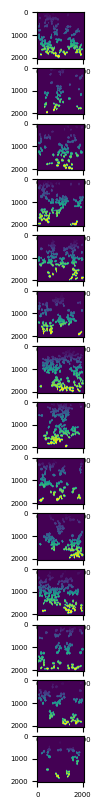

In [41]:
fig, axs = [],[]
fig, axs = plt.subplots(num_of_imgs,1, figsize=(10,10))
plt.rcParams["font.size"] =5
for i in range(num_of_imgs):
    axs[i].imshow(result[0][i])

In [42]:
for i in range(num_of_imgs):
    file_name = os.path.basename(list_of_imgs[i]).split(".")[0]
    io.masks_flows_to_seg(images=imgs[i], masks=result[0][i], 
                          flows=result[1][i], 
                          diams=None, 
                          file_names=os.path.join(path_to_outdir, file_name)
    )
    
    io.save_masks(images=imgs[i], masks=result[0][i],
                  flows=result[1][i], 
                  file_names = os.path.join(path_to_outdir, file_name)
    )
    io.save_rois(masks=result[0][i],
                file_name = os.path.join(path_to_outdir, file_name)
    )

In [43]:
# マスク画像のパスのリストを取得
common_name_mask = "*_cp_masks.png"
list_of_masks = glob(os.path.join(path_to_outdir, common_name_mask))
list_of_masks.sort()

# 明視野画像のパスのリストを取得
common_name_bf = "Image*.tif"
list_of_bfs = glob(os.path.join(path_to_indir, common_name_bf))
list_of_bfs.sort()

# Merge画像のパスのリストを取得
common_name_merges = "Series*_Processed001.tif"
list_of_merges = glob(os.path.join(path_to_indir, common_name_merges))
list_of_merges.sort()

# ch00画像のパスのリストを取得
common_name_ch00 = "Series*_Processed001_ch00.tif"
list_of_ch00 = glob(os.path.join(path_to_indir, common_name_ch00)) 
list_of_ch00.sort()

# ch01画像のパスのリストを取得
common_name_ch01 = "Series*_Processed001_ch01.tif"
list_of_ch01 = glob(os.path.join(path_to_indir, common_name_ch01))
list_of_ch01.sort()

for index, i_mask in enumerate(list_of_masks):
    # cv2を使ってマスク画像を読み込む
    mask_array = cv2.imread(i_mask, cv2.IMREAD_UNCHANGED)
    
    # まずはbfの画像からROIを切り抜く
    if len(list_of_bfs) != 0:
        path_img = list_of_bfs[index]
        name_outdir = os.path.basename(path_img).split(".")[0]
        path_outdir = os.path.join(path_to_outdir, "crop_roi_" + name_outdir)    
        crop_roi(path_img, mask_array, path_outdir, size=100, sum=False)
    
    # mergeの画像からROIを切り抜く
    if len(list_of_merges) != 0:
        path_img = list_of_merges[index]
        name_outdir = os.path.basename(path_img).split(".")[0]
        path_outdir = os.path.join(path_to_outdir, "crop_roi_" + name_outdir)
        crop_roi(path_img, mask_array, path_outdir, size=100, sum=False)

    # ch00の画像からROIを切り抜く
    if len(list_of_ch00) != 0:
        path_img = list_of_ch00[index]
        name_outdir = os.path.basename(path_img).split(".")[0]
        path_outdir = os.path.join(path_to_outdir, "crop_roi_" + name_outdir)
        crop_roi(path_img, mask_array, path_outdir, size=100, sum=False)
    
    # ch01の画像からROIを切り抜く
    if len(list_of_ch01) != 0:        
        path_img = list_of_ch01[index]
        name_outdir = os.path.basename(path_img).split(".")[0]
        path_outdir = os.path.join(path_to_outdir, "crop_roi_" + name_outdir)
        crop_roi(path_img, mask_array, path_outdir, size=100, sum=True)




=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image001_420min.tif ===


100%|██████████| 114/114 [00:10<00:00, 10.84it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series002_420min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 114/114 [00:07<00:00, 14.99it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image001_420min_ch00.tif ===


100%|██████████| 49/49 [00:04<00:00, 10.79it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series004_420min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 49/49 [00:02<00:00, 23.01it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image001_420min_ch01.tif ===


100%|██████████| 70/70 [00:05<00:00, 12.13it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series006_480min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 70/70 [00:05<00:00, 12.70it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image003_420min.tif ===


100%|██████████| 95/95 [00:09<00:00, 10.37it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series008_540min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 95/95 [00:07<00:00, 13.52it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image003_420min_ch00.tif ===


100%|██████████| 103/103 [00:07<00:00, 14.55it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series010_540min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 103/103 [00:07<00:00, 14.52it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image003_420min_ch01.tif ===


100%|██████████| 85/85 [00:06<00:00, 12.27it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series012_600min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 85/85 [00:06<00:00, 13.64it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image005_480min.tif ===


100%|██████████| 136/136 [00:11<00:00, 11.80it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series014_600min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 136/136 [00:08<00:00, 15.94it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image005_480min_ch00.tif ===


100%|██████████| 104/104 [00:09<00:00, 10.64it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series016_600min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 104/104 [00:07<00:00, 14.67it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image005_480min_ch01.tif ===


100%|██████████| 71/71 [00:05<00:00, 12.17it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series018_660min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 71/71 [00:05<00:00, 12.45it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image007_540min.tif ===


100%|██████████| 90/90 [00:06<00:00, 12.93it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series020_660min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 90/90 [00:08<00:00, 10.22it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image007_540min_ch00.tif ===


100%|██████████| 119/119 [00:08<00:00, 14.35it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series022_660min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 119/119 [00:10<00:00, 11.51it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image007_540min_ch01.tif ===


100%|██████████| 72/72 [00:05<00:00, 13.00it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series024_720min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 72/72 [00:03<00:00, 22.21it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image009_540min.tif ===


100%|██████████| 66/66 [00:03<00:00, 19.47it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series026_720min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 66/66 [00:06<00:00, 10.37it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Image009_540min_ch00.tif ===


100%|██████████| 34/34 [00:01<00:00, 21.34it/s]


=== /mnt/g/20231221_thunder_YSIY1475_YSIY944_spo_6hr-12hr/Project002_YSIY1475_without-IAA/Series028_720min_Lng_SVCC_Processed001_ch00.tif ===


100%|██████████| 34/34 [00:01<00:00, 24.16it/s]
